# What this notebook does:

1. Loads training and validation data

2. Try model on as-is data

3. Advanced cleaning

4. Basic Feature Engineering

# Imports and Setup

In [23]:
import re
import warnings

import flaml
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ppscore as pps
import seaborn as sns
from pandas_profiling import ProfileReport
from phik import phik_matrix
from sklearn.metrics import (accuracy_score,
                             f1_score)
from supervised import AutoML

%matplotlib inline
sns.set()
warnings.filterwarnings("ignore")


# Load Data

In [2]:
trainset = pd.read_csv('../Data/trainset.csv')
valset = pd.read_csv('../Data/valset.csv')

In [17]:
X_train = trainset.drop(["Anxiety", "Depression", "Compulsive behavior"], axis=1)
y_train_anxiety = trainset["Anxiety"]
y_train_depression = trainset["Depression"]
y_train_compulsive_behavior = trainset["Compulsive behavior"]
X_val = valset.drop(["Anxiety", "Depression", "Compulsive behavior"], axis=1)
y_val_anxiety = valset["Anxiety"]
y_val_depression = valset["Depression"]
y_val_compulsive_behavior = valset["Compulsive behavior"]

In [18]:
print(X_train.shape)
print(y_train_anxiety.shape)
print(y_train_depression.shape)
print(y_train_compulsive_behavior.shape)
print(X_val.shape)
print(y_val_anxiety.shape)
print(y_val_depression.shape)
print(y_val_compulsive_behavior.shape)

(235, 28)
(235,)
(235,)
(235,)
(11, 28)
(11,)
(11,)
(11,)


In [19]:
X_train.head()

,I am currently employed at least part-time,I identify as having a mental illness,Education,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,...,Lack of concentration,Obsessive thinking,Mood swings,Panic attacks,Tiredness,Age,Gender,Household Income,Region,Device Type
0,0,0,Completed Undergraduate,1,0,0.0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,45-60,Female,Prefer not to answer,West South Central,Android Phone / Tablet
1,1,0,Completed Masters,1,0,0.0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,30-44,Male,"$200,000+",East South Central,iOS Phone / Tablet
2,0,1,Completed Undergraduate,0,0,78.0,1,1,1,0,...,0.0,0.0,1.0,0.0,0.0,30-44,Male,"$0-$9,999",Middle Atlantic,Android Phone / Tablet
3,0,0,Completed Undergraduate,1,0,0.0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,30-44,Male,"$0-$9,999",Mountain,iOS Phone / Tablet
4,0,0,Some Undergraduate,1,0,0.0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,> 60,Female,Prefer not to answer,Mountain,Android Phone / Tablet


# Try model on as-is data

To set a very basic baseline lets create models using MLJAR (for exploration) and FLAML so that we can start improving.

We will write a function which will use FLAML to create a baseline:

In [26]:
def set_baseline(X_train, y_train, X_val, y_val, name, time_limit=120):
    explainer = AutoML(results_path=f"../Reports/MLJAR/{name}", total_time_limit=round(time_limit), mode="Explain", ml_task="binary_classification")
    explainer.fit(X_train, y_train)

    print("Performance for explainer")
    print(" ")
    print(f"Accuracy Score on train set: {round(accuracy_score(y_train, explainer.predict(X_train))*100, 4)}%")
    print(f"Accuracy Score on validation set: {round(accuracy_score(y_val, explainer.predict(X_val))*100, 4)}%")
    print(f"F1 Score on train set: {round(f1_score(y_train, explainer.predict(X_train)), 4)}")
    print(f"F1 Score on validation set: {round(f1_score(y_val, explainer.predict(X_val)), 4)}")
    print("\n--------------------\n\n")


## Anxiety:

In [27]:
set_baseline(X_train, y_train_anxiety, X_val, y_val_anxiety, "baseline_anxiety", time_limit=2*60)

This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.
Performance for explainer
 
Accuracy Score on train set: 85.1064%
Accuracy Score on validation set: 100.0%
F1 Score on train set: 0.7651
F1 Score on validation set: 1.0

--------------------




Great we now have a baseline. As you can see the performance is satisfactory but we will try to improve on it.

Now lets create another function which will use FLAML. We will use this function from now on as we don't need to set baselines (and do this EDA) over and over again. This function will also return feature importances, ppscore, phik correlation in addition to the metrics we are interested in. 

**Note:** This is not code for the final model. This will only be used to test if the feature engineering we are doing has a positive effect on the model. The final model will run for longer and we will spend much more time on it.

In [31]:
def get_performance(X_train, y_train, X_val, y_val, target_col_name, time_limit=60, figsize=(8, 8)):
    automl_settings = {
            "time_budget": round(time_limit),  # in seconds
            "metric": "f1",
            "task": 'classification',
            "ensemble": False,
            "verbose": 0,
            "log_file_name":"",
            "n_jobs":-1
        }
    
    automl = flaml.AutoML()
    automl.fit(X_train, y_train, X_val = X_val, y_val = y_val, **automl_settings)
    
    print(" ")
    print("Model Performance")
    print(" ")
    print(f"Accuracy Score on train set: {round(accuracy_score(y_train, automl.predict(X_train))*100, 4)}%")
    print(f"Accuracy Score on validation set: {round(accuracy_score(y_val, automl.predict(X_val))*100, 4)}%")
    print(f"F1 Score on train set: {round(f1_score(y_train, automl.predict(X_train)), 4)}")
    print(f"F1 Score on validation set: {round(f1_score(y_val, automl.predict(X_val)), 4)}")
    print("\n--------------------\n\n")

    print("Estimator:")
    print(automl.model.estimator)
    print("\n--------------------\n\n")

    # Plot the feature importances as a bar graph is descending order:
    importances = automl.model.estimator.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature_name': feature_names, 'importance': importances})
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    plt.figure(figsize=figsize)
    sns.barplot(x='importance', y='feature_name', data=feature_importances)
    plt.title("Feature Importances")
    plt.tight_layout()
    plt.xlim(0, 1)
    plt.show()

    full_df = pd.concat([X_train, y_train], axis=1)
    predictors_df = pps.predictors(full_df, y=target_col_name)
    plt.figure(figsize=figsize)
    sns.barplot(data=predictors_df, x="ppscore", y="x")

    phik_overview = full_df.phik_matrix()
    target_overview = phik_overview[target_col_name].sort_values(ascending=False)
    target_overview.drop(target_col_name, inplace=True)

    # Create bar plot using index and values:
    plt.figure(figsize=(8,8))
    sns.barplot(x=target_overview.values, y=target_overview.index)
    plt.show()

Lets test this function

2022-06-26 08:40:47,932 flaml.searcher.blendsearch INFO No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


 
Model Performance
 
Accuracy Score on train set: 84.6809%
Accuracy Score on validation set: 100.0%
F1 Score on train set: 0.7353
F1 Score on validation set: 1.0

--------------------


Estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.09999999999999995,
              max_delta_step=0, max_depth=0, max_leaves=4,
              min_child_weight=0.9999999999999993, missing=nan,
              monotone_constraints='()', n_estimators=1, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
              reg_lambda=1.0, scale_pos_weight=1, subsample=1.0,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

--------------------




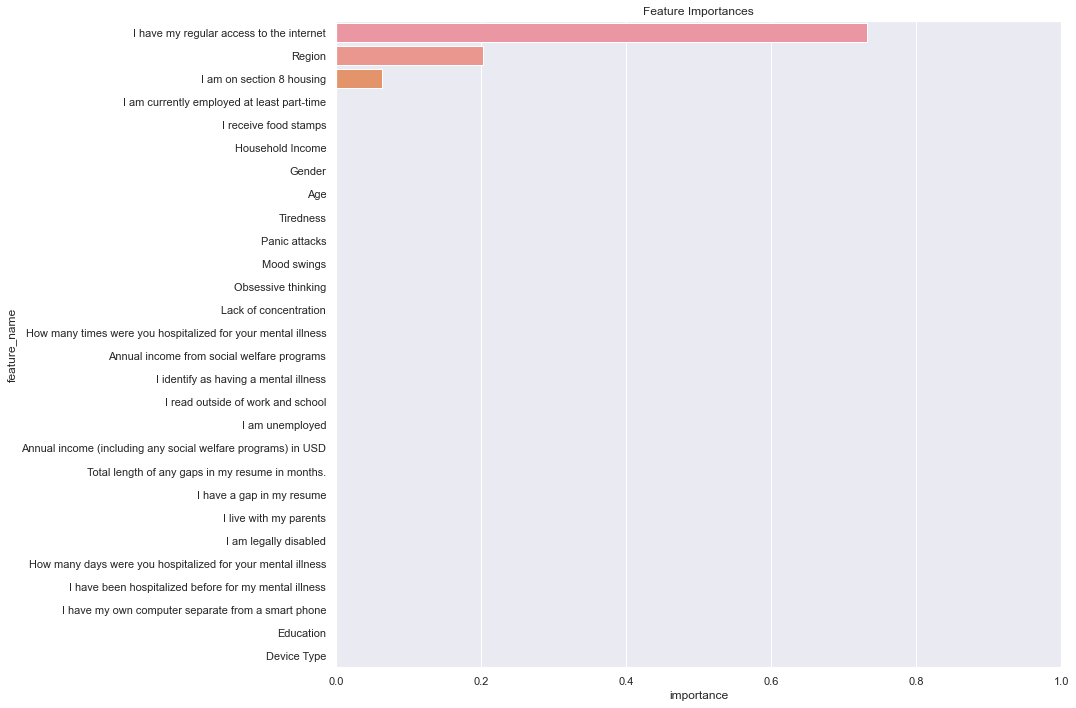

interval columns not set, guessing: ['I am currently employed at least part-time', 'I identify as having a mental illness', 'I have my own computer separate from a smart phone', 'I have been hospitalized before for my mental illness', 'How many days were you hospitalized for your mental illness', 'I am legally disabled', 'I have my regular access to the internet', 'I live with my parents', 'I have a gap in my resume', 'Total length of any gaps in my resume in\xa0months.', 'Annual income (including any social welfare programs) in USD', 'I am unemployed', 'I read outside of work and school', 'Annual income from social welfare programs', 'I receive food stamps', 'I am on section 8 housing', 'How many times were you hospitalized for your mental illness', 'Lack of concentration', 'Obsessive thinking', 'Mood swings', 'Panic attacks', 'Tiredness', 'Anxiety']


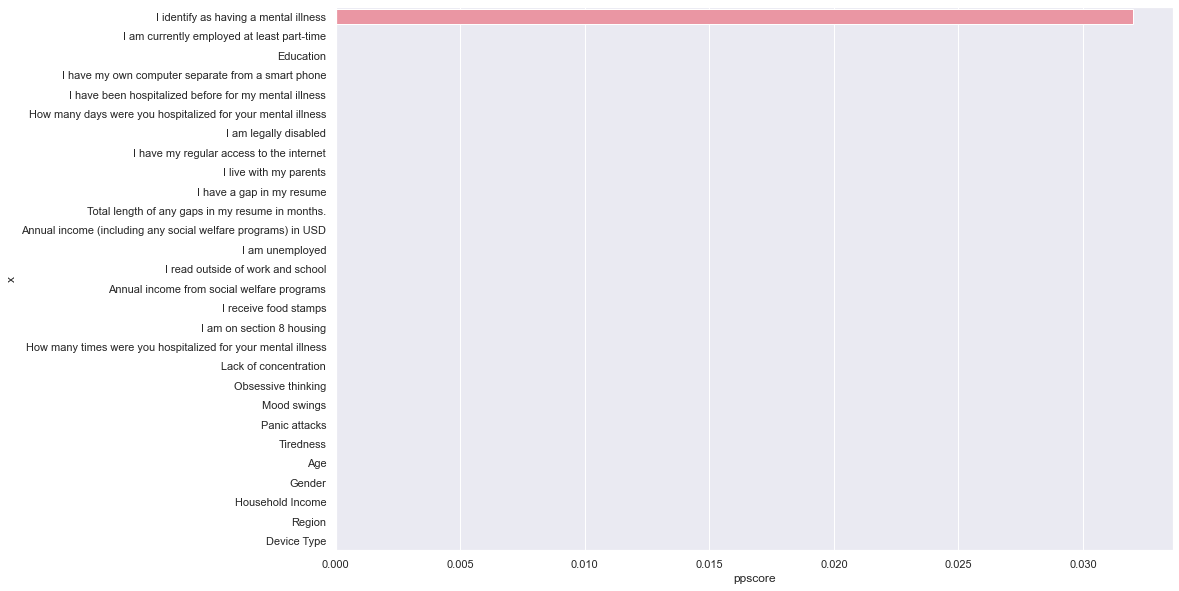

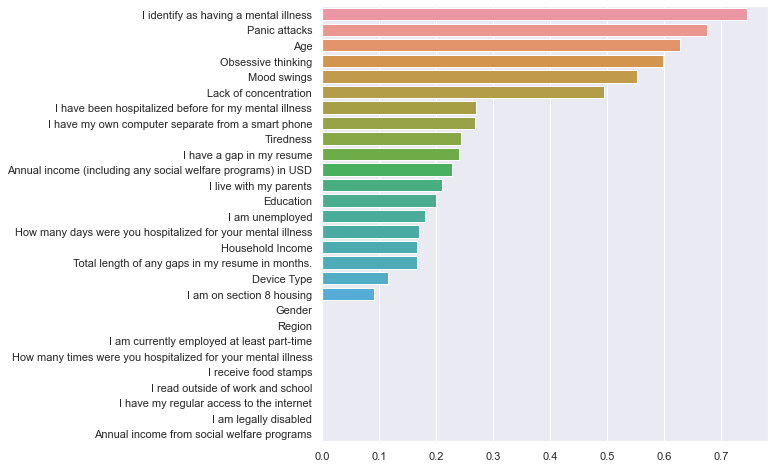

In [32]:
get_performance(X_train, y_train_anxiety, X_val, y_val_anxiety, target_col_name="Anxiety", time_limit=5*60, figsize=(15, 10))

Great we can see that the performance of FLAML is already a bit better than our baseline. We can also see which features are the most important. Lets do the same for our other targets as well.

# Depression

In [33]:
set_baseline(X_train, y_train_depression, X_val, y_val_depression, "baseline_depression", time_limit=2*60)

AutoML directory: ../Reports/MLJAR/baseline_depression
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.584566 trained in 1.18 seconds
Exception while producing SHAP explanations. Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.
Continuing ...
2_DecisionTree logloss 0.434383 trained in 45.53 seconds
Exception while producing SHAP explanations. Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.
Continuing ...
3_Linear logloss 0.390355 trained in 4.92 seconds
* Step default_algorithms will try to check up to 3 model

2022-06-26 08:48:46,292 flaml.searcher.blendsearch INFO No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


 
Model Performance
 
Accuracy Score on train set: 88.0851%
Accuracy Score on validation set: 100.0%
F1 Score on train set: 0.7667
F1 Score on validation set: 1.0

--------------------


Estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.09999999999999995,
              max_delta_step=0, max_depth=0, max_leaves=4,
              min_child_weight=0.9999999999999993, missing=nan,
              monotone_constraints='()', n_estimators=1, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
              reg_lambda=1.0, scale_pos_weight=1, subsample=1.0,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

--------------------




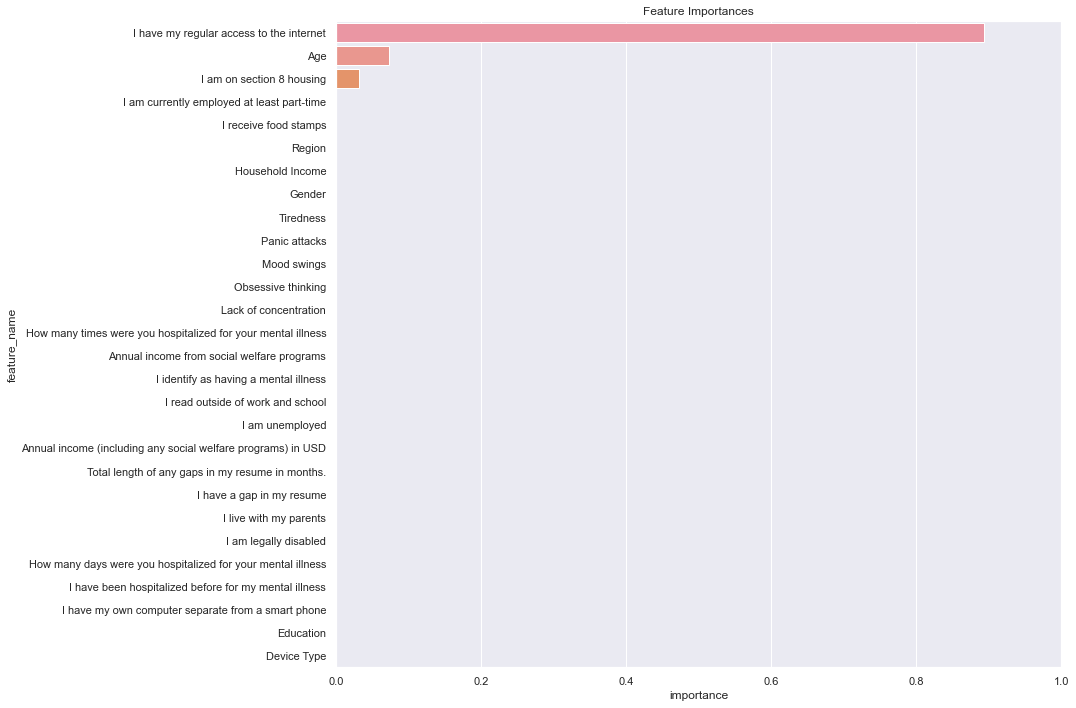

interval columns not set, guessing: ['I am currently employed at least part-time', 'I identify as having a mental illness', 'I have my own computer separate from a smart phone', 'I have been hospitalized before for my mental illness', 'How many days were you hospitalized for your mental illness', 'I am legally disabled', 'I have my regular access to the internet', 'I live with my parents', 'I have a gap in my resume', 'Total length of any gaps in my resume in\xa0months.', 'Annual income (including any social welfare programs) in USD', 'I am unemployed', 'I read outside of work and school', 'Annual income from social welfare programs', 'I receive food stamps', 'I am on section 8 housing', 'How many times were you hospitalized for your mental illness', 'Lack of concentration', 'Obsessive thinking', 'Mood swings', 'Panic attacks', 'Tiredness', 'Depression']


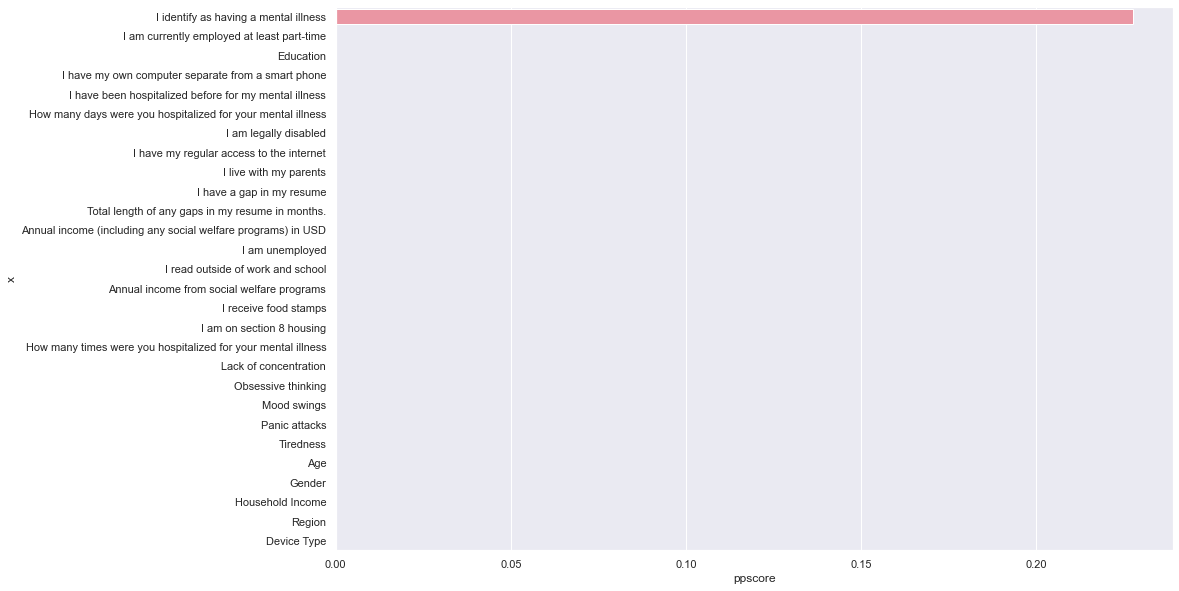

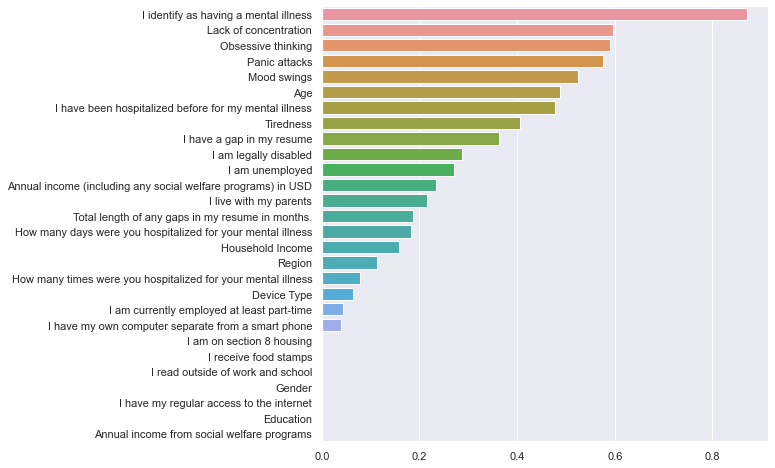

In [34]:
get_performance(X_train, y_train_depression, X_val, y_val_depression, target_col_name="Depression", time_limit=5*60, figsize=(15, 10))

# Compulsive Behavior

In [35]:
set_baseline(X_train, y_train_compulsive_behavior, X_val, y_val_compulsive_behavior, "baseline_compulsive_behavior", time_limit=2*60)

AutoML directory: ../Reports/MLJAR/baseline_compulsive_behavior
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.290211 trained in 2.37 seconds
Exception while producing SHAP explanations. Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.
Continuing ...
2_DecisionTree logloss 1.463251 trained in 38.09 seconds
Exception while producing SHAP explanations. Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.
Continuing ...
3_Linear logloss 0.334622 trained in 5.14 seconds
* Step default_algorithms will try to check up t

2022-06-26 09:04:19,507 flaml.searcher.blendsearch INFO No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


 
Model Performance
 
Accuracy Score on train set: 95.7447%
Accuracy Score on validation set: 100.0%
F1 Score on train set: 0.6875
F1 Score on validation set: 1.0

--------------------


Estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.09999999999999995,
              max_delta_step=0, max_depth=0, max_leaves=4,
              min_child_weight=0.9999999999999993, missing=nan,
              monotone_constraints='()', n_estimators=4, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0009765625,
              reg_lambda=1.0, scale_pos_weight=1, subsample=1.0,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

--------------------




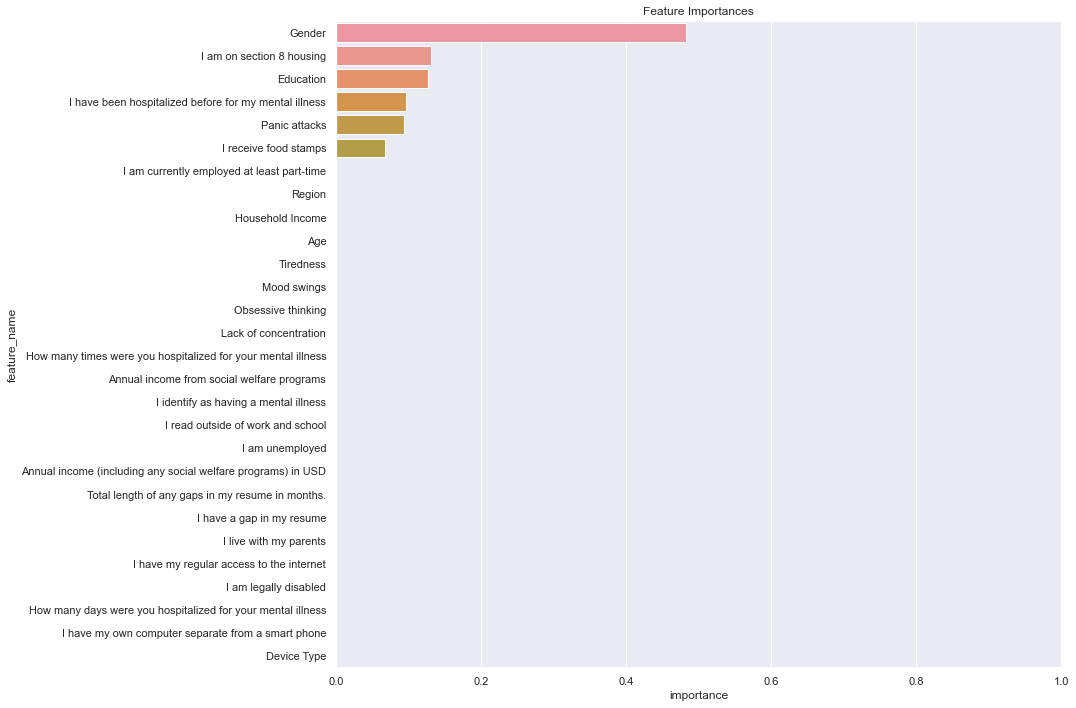

interval columns not set, guessing: ['I am currently employed at least part-time', 'I identify as having a mental illness', 'I have my own computer separate from a smart phone', 'I have been hospitalized before for my mental illness', 'How many days were you hospitalized for your mental illness', 'I am legally disabled', 'I have my regular access to the internet', 'I live with my parents', 'I have a gap in my resume', 'Total length of any gaps in my resume in\xa0months.', 'Annual income (including any social welfare programs) in USD', 'I am unemployed', 'I read outside of work and school', 'Annual income from social welfare programs', 'I receive food stamps', 'I am on section 8 housing', 'How many times were you hospitalized for your mental illness', 'Lack of concentration', 'Obsessive thinking', 'Mood swings', 'Panic attacks', 'Tiredness', 'Compulsive behavior']


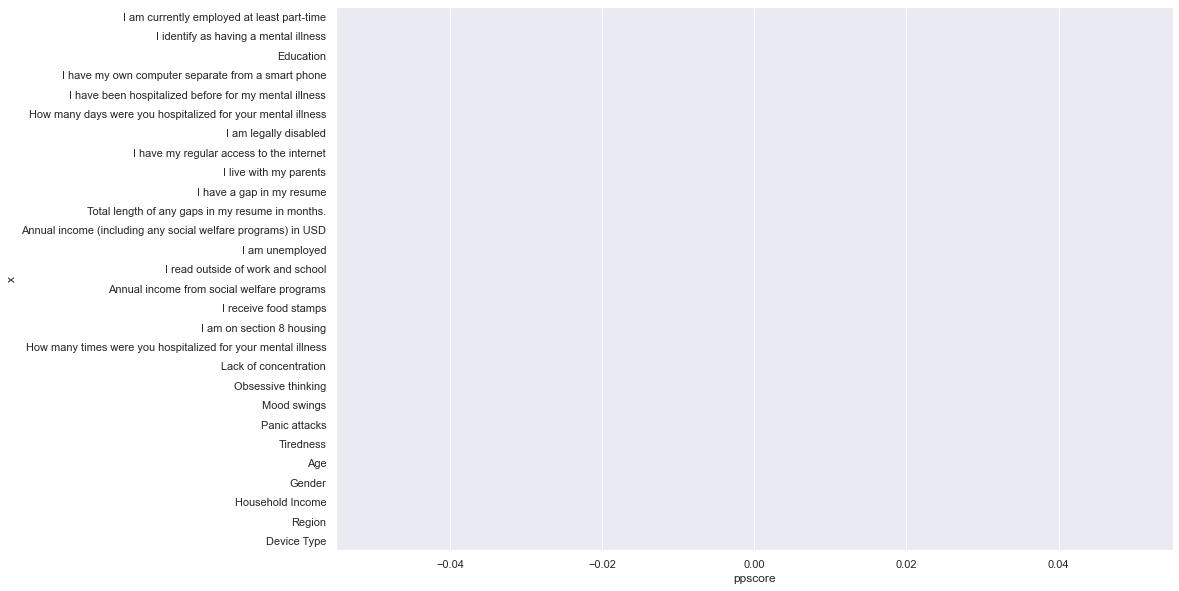

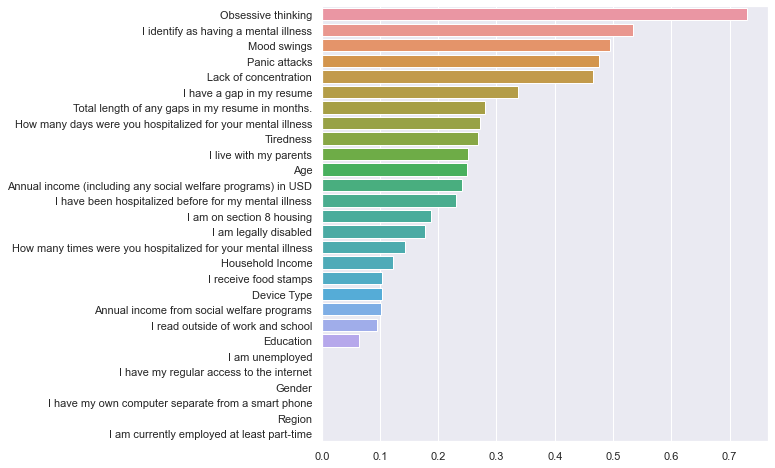

In [37]:
get_performance(X_train, y_train_compulsive_behavior, X_val, y_val_compulsive_behavior, target_col_name="Compulsive behavior", time_limit=5*60, figsize=(15, 10))

# Done!